# Import and Load data

In [1]:
import gc
import pandas as pd # type:ignore
import numpy as np # type:ignore
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder # type:ignore
from scipy.sparse import csr_matrix # type:ignore
from scipy.stats import zscore # type:ignore
from sklearn.decomposition import PCA # type:ignore
from sklearn.model_selection import GridSearchCV, train_test_split # type:ignore
from sklearn.linear_model import LogisticRegression # type:ignore
from sklearn.metrics import classification_report, accuracy_score # type:ignore
import matplotlib.pyplot as plt # type:ignore
import seaborn as sns # type:ignore

In [2]:
# Load the datasets
train_data = pd.read_csv('train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

# Clean the data

In [3]:
# Check missing values
train_data.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [4]:
# Look the categories of each column
for column in train_data.columns:
        unique_values = train_data[column].unique()
        print(f"Column: {column}")
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Categories/Values: {unique_values}")
        print("-" * 80)

Column: id
Number of unique values: 3116945
Categories/Values: [      0       1       2 ... 3116942 3116943 3116944]
--------------------------------------------------------------------------------
Column: class
Number of unique values: 2
Categories/Values: ['e' 'p']
--------------------------------------------------------------------------------
Column: cap-diameter
Number of unique values: 3914
Categories/Values: [ 8.8   4.51  6.94 ... 38.11 55.63 54.07]
--------------------------------------------------------------------------------
Column: cap-shape
Number of unique values: 75
Categories/Values: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04

In [3]:
# Consider column categories

def clean_column_categories(df):
    """
    Cleans all columns in the DataFrame by:
    - Ensuring columns are of category type unless they are numerical.
    - Replacing NaN values with 'unknown'.
    - Validating that single-character strings are kept as valid categories.
    - Replacing invalid values with 'invalid'.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to clean.
    
    Returns:
    pandas.DataFrame: The cleaned DataFrame.
    """
    
    def clean_value(value):
        """
        Cleans individual values based on the defined rules.
        """
        if value == 'unknown':  # Preserve 'unknown' values
            return value
        elif isinstance(value, str) and len(value.strip()) == 1:
            return value.strip()
        else:
            return 'invalid'
    
    for column in df.columns:
        # Skip numerical columns
        if pd.api.types.is_numeric_dtype(df[column]) or column == 'class':
            continue
        
        # Convert to 'category' dtype if not numerical
        df[column] = df[column].astype('category')
        
        # Add 'unknown' and 'invalid' to the category list
        df[column] = df[column].cat.add_categories(['unknown', 'invalid'])
        
        # Replace NaN values with 'unknown' and apply the cleaning logic
        df[column] = df[column].fillna('unknown').map(clean_value)
    
    return df


In [4]:
# Create a clean df
clean_train_data = train_data.drop(columns=['id'])

# Clean the categories
clean_train_data = clean_column_categories(clean_train_data)

# Fill null values in 'cap-diameter' with the mean
clean_train_data['cap-diameter'] = clean_train_data['cap-diameter'].fillna(
    clean_train_data['cap-diameter'].mean())
# Show if there are null values in the df
print(clean_train_data.isnull().sum())

# Clear memory
del train_data
gc.collect()


class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


0

In [7]:
# Look the categories of each column
for column in clean_train_data.columns:
        unique_values = clean_train_data[column].unique()
        print(f"Column: {column}")
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Categories/Values: {unique_values}")
        print("-" * 80)

Column: class
Number of unique values: 2
Categories/Values: ['e' 'p']
--------------------------------------------------------------------------------
Column: cap-diameter
Number of unique values: 3914
Categories/Values: [ 8.8   4.51  6.94 ... 38.11 55.63 54.07]
--------------------------------------------------------------------------------
Column: cap-shape
Number of unique values: 26
Categories/Values: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' 'unknown' 'w' 'k' 'l' 'invalid'
 't' 'g' 'z' 'a' 'r' 'u' 'y' 'i' '8' 'm' 'h']
--------------------------------------------------------------------------------
Column: cap-surface
Number of unique values: 25
Categories/Values: ['s' 'h' 'y' 'l' 't' 'e' 'g' 'unknown' 'd' 'i' 'w' 'k' 'invalid' 'f' 'n'
 'r' 'o' 'a' 'u' 'z' 'p' 'b' 'm' 'x' 'c']
--------------------------------------------------------------------------------
Column: cap-color
Number of unique values: 26
Categories/Values: ['u' 'o' 'b' 'g' 'w' 'n' 'e' 'y' 'r' 'p' 'k' 'l' 'i' 'h' 'd' 's

# Initial analysis

### Correlation Analysis

In [5]:
# Separate the target column
target_column = clean_train_data['class']
features_data = clean_train_data.drop(columns=['class'])

# Clear memory
del clean_train_data
gc.collect()

0

In [6]:
# Apply OneHotEncoder to categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=True)
encoded_train = encoder.fit_transform(
    features_data.select_dtypes(include=['category', 'object']))

# Add again the numerical columns
numerical_train = features_data.select_dtypes(include=[np.number])
encoded_matrix= csr_matrix(np.hstack([encoded_train.toarray(), 
                                      numerical_train.values]))

# Correlation matrix
corr_matrix_sparse = np.corrcoef(encoded_matrix.toarray(), rowvar=False)

# Clear memory
del features_data, encoded_train
gc.collect()

0

In [7]:
# Analyze the correlation
# Get all the features names
categorical_feature_names = encoder.get_feature_names_out()
numerical_feature_names = numerical_train.columns
all_feature_names = np.hstack(
    [categorical_feature_names, numerical_feature_names])

# Convert correlation array to DataFrame
corr_df = pd.DataFrame(
    corr_matrix_sparse, index=all_feature_names, columns=all_feature_names)

# Set a threshold for high correlation
threshold = 0.8

# Find pairs of columns with correlation above the threshold
high_corr = (corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
             .stack()
             .reset_index()
             .rename(columns={0: 'correlation'})
             .query('abs(correlation) > @threshold'))

print(high_corr)

# Clear memory
del categorical_feature_names, numerical_feature_names, corr_df
del corr_matrix_sparse, numerical_train
gc.collect()

                      level_0                 level_1  correlation
27116  does-bruise-or-bleed_f  does-bruise-or-bleed_t    -0.999870
34246       gill-attachment_f          gill-spacing_f     0.994906
34268       gill-attachment_f            gill-color_f     0.995787
41301          gill-spacing_f            gill-color_f     0.993694
52136             stem-root_f          stem-surface_f     0.924257
52160             stem-root_f            stem-color_f     0.960879
56948          stem-surface_f            stem-color_f     0.882482
66435             veil-type_u       veil-type_unknown    -0.999739
69020      veil-color_unknown            veil-color_w    -0.846676
69753              has-ring_f              has-ring_t    -0.999874
69766              has-ring_f             ring-type_f     0.903410
70962              has-ring_t             ring-type_f    -0.903310


0

In [8]:
# Consider the correlated columns
columns_to_remove = set()
for col1, col2 in high_corr[['level_0', 'level_1']].values:
    # Avoid removing both columns if they are in multiple high-correlation pairs
    columns_to_remove.add(col1)
indices_to_remove = [i for i, col in enumerate(all_feature_names) if col in columns_to_remove]
cleaned_feature_names = np.delete(all_feature_names, indices_to_remove)

# Remove redundant columns from encoded data
encoded_dense_matrix = encoded_matrix.toarray()
encoded_dense_matrix_cleaned = np.delete(
    encoded_dense_matrix, indices_to_remove, axis=1)

# Create a pandas DataFrame with cleaned data and feature names
cleaned_df = pd.DataFrame(
    encoded_dense_matrix_cleaned, columns=cleaned_feature_names)
cleaned_df.info()

# Clear memory
del encoded_dense_matrix, encoded_dense_matrix_cleaned
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Columns: 378 entries, cap-shape_a to stem-width
dtypes: float64(378)
memory usage: 8.8 GB


0

### Principal Component Analysis

In [9]:
# Standardize the data (excluding the target column)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(cleaned_df)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_transformed_data = pca.fit_transform(standardized_data)

# Analyze the Explained Variance
# explained_variance = pca.explained_variance_ratio_

# Convert back to DataFrame for further analysis
cleaned_df = pd.DataFrame(pca_transformed_data)
cleaned_df.info()

# Clear memory
del standardized_data, pca_transformed_data
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Columns: 325 entries, 0 to 324
dtypes: float64(325)
memory usage: 7.5 GB


0

# Model preparation

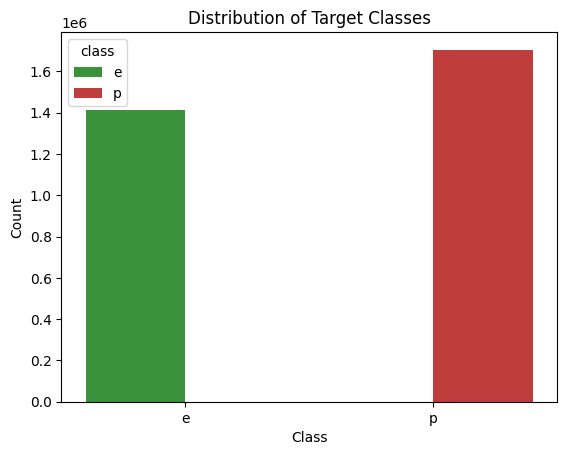

3400

In [10]:
# See if theres class disbalance
# Convert the Series to a DataFrame
target_df = target_column.to_frame(name='class')

# Plot the distribution of the target column
colors = ['#2ca02c', '#d62728']
# Plot the distribution of the target column with custom colors
sns.countplot(x='class', data=target_df, hue='class', palette=colors)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes')

# Display the plot
plt.show()

# Clear memory
del target_column
gc.collect()

### Handle Outliers

In [11]:
# Heavy computation, may skip

# Calculate the Z-scores of the features
z_scores = cleaned_df.apply(zscore)

# Define a threshold
threshold = 3

# Find rows where any feature's Z-score exceeds the threshold
outliers = (np.abs(z_scores) > threshold).any(axis=1)

# Filter out the outliers from the dataset
cleaned_df_no_outliers = cleaned_df[~outliers]
target_column_no_outliers = target_df[~outliers]
cleaned_df_no_outliers.info()

# Clear memory
del z_scores, outliers
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Index: 2457682 entries, 0 to 3116944
Columns: 325 entries, 0 to 324
dtypes: float64(325)
memory usage: 6.0 GB


0

# Logistic Regression training

In [12]:
# Encode the target column
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(
    target_column_no_outliers.values.ravel())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_no_outliers, target_encoded, 
    test_size=0.2, random_state=42, stratify=target_encoded
)

# Ensure the features are still scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Clear memory
del cleaned_df_no_outliers, target_column_no_outliers
del X_train, X_test, cleaned_df, target_df, target_encoded
gc.collect()

0

### Optimize Numeric Data Types

In [13]:
# Function to optimize the data types of a DataFrame
def optimize_dataframe(df):
    """Optimize the data types of a pandas DataFrame to reduce memory usage.

    This function downcasts the data types of integer and float columns in 
    the DataFrame to more memory-efficient types. Specifically:
    - Integer columns are downcasted to the smallest unsigned integer type.
    - Float columns are downcasted to the smallest float type.

    Parameters:
    ----------
    df : pandas.DataFrame

    Returns:
    -------
    pandas.DataFrame
        The DataFrame with optimized data types, which consumes less memory.
    """
    # Optimize integers
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')
    
    # Optimize floats
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    return df


In [14]:
X_train_optimized = optimize_dataframe(pd.DataFrame(X_train_scaled))
X_test_optimized = optimize_dataframe(pd.DataFrame(X_test_scaled))

# Ensure categorical columns are in dtype=category
for col in X_train_optimized.select_dtypes(include=['object']).columns:
    X_train_optimized[col] = X_train_optimized[col].astype('category')


In [15]:
# Assure data integrity
print("Original row count:", len(X_train_scaled))
print("Optimized row count:", len(X_train_optimized))

# Clear memory
del X_train_scaled, X_test_scaled
gc.collect()

Original row count: 1966145
Optimized row count: 1966145


0

### Model training

In [18]:
# Inicializar el modelo de regresión logística con parámetros por defecto
model = LogisticRegression(max_iter=10000)

# Entrenar el modelo
model.fit(X_train_optimized, y_train)

LogisticRegression(max_iter=10000)

In [17]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_optimized)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", 
      classification_report(y_test, y_pred))

Test Accuracy: 0.84702474076214
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85    241583
           1       0.86      0.83      0.85    249954

    accuracy                           0.85    491537
   macro avg       0.85      0.85      0.85    491537
weighted avg       0.85      0.85      0.85    491537



### Save the model

In [ ]:
import joblib

# Guarda el modelo entrenado en un archivo
joblib.dump(model, 'logistic_regression_model.pkl')


In [ ]:
import joblib

# Carga el modelo desde el archivo
loaded_model = joblib.load('logistic_regression_model.pkl')